<a href="https://colab.research.google.com/github/guiattard/PythonForGeosciences/blob/master/predicting-thermal-plumes-of-groundwater-heat-pump-systems/Predicting-thermal-plume-GWHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Thermal Plume of groundwater heat pump systems

Notebook created by Guillaume Attard (2/05/2020)

https://guillaumeattard.com

## Introduction

The thermal impact assessment is a crucial step in a geothermal project. Particularly in regards of geothermal energy planning. In this regard, analytical solutions are straightforward tools for a preliminary impact assessment. In this article we explore three analytical solutions which can help to estimate the thermal impact caused by groundwater heat pump systems. The valididy of these (semi-)analytical solutions was discussed in details by Pophillat et al. (2020) [1]. Now, let’s dive into these equations.

## Table of content


- Problem settings
- Definition of three 2D(semi-)analytical models,
- Creation of a grid over a region of interest using numpy,
- Plotting the results using matplotlib,
- Illustation in case of multiple installations,
- Exporting the results in a shapefile using shapely, pandas and geopandas.

## Problem settings


Here we study the thermal impact of a hot water injection in an aquifer. The parameters of the problem read as follow:

- we study the thermal impact in a 2D plane $x,y$,
- the water injection rate is $Q_{inj}$ and temperature difference between injection groundwater background temperature is $\Delta T_{inj}$,
- the groundwater is flowing with an angle $\alpha$from positives $x$,
- the injection is located in $X_{0}$, $Y_{0}$,
- the background groundwater seepgae velocity is $v_{a}$, the effective porosity of the aquifer is $n$ and its thickness is $b$,
- we also need to define some hydraulic/thermal parameters such as : thermal conductivity of the aquifer ($\lambda _{m}$), volumetric heat capacity of the aquifer and of water ($ _{m,w}$), longitudinal and transverse dispersivities ($\alpha _{L,T}$),
- we calculate the temperature alteration after a time $t$ of injection.

## Definition of 2D(semi-)analytical models


To define our models of intereset, we first need to import some usefull librairies.


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.special import erf,erfc,erfcinv

#### Radial Heat Transport Model

The radial heat transport model [2] is appropriate when the background groundwater flow velocity is almost zero. In that case, the injection of the heated water creates a radial thermal disturbance according to following equation:

$\Delta T(x,y,t ) = \frac{1}{2} \text{erfc} \left(\frac{r^{2}- r*^{2}}{2 \left(\frac{4}{3} \alpha _{L} r*^{3} + \frac{\lambda _{m}}{A_{T} C_{m}} r*^{4}\right)^{1/2} }\right)$

with: $r* = \left( 2 A_{T}t \right)^{1/2}$, $A_{T} = \frac{Q_{inj}}{2R \pi n b}$ and $R = \frac{C_{m}}{nC_{w}}$ 

In [ ]:
def RHT(x,y,X0,Y0,t,Qinj,DTinj,b,va,n,C_m,C_w,alpha_L,alpha_T,lambda_m):
    R = C_m/(n*C_w)
    At = (1/R)*(Qinj/(2*np.pi*n*b))
    rp = np.sqrt(2*At*t)
     
    x = x - X0                                                          
    y = y - Y0 
     
    r = np.sqrt(x**2+y**2)
     
    return (DTinj/2)*erfc((r**2-rp**2)/(2*np.sqrt((4*alpha_L/3)*(rp**3)+(lambda_m/At/C_m)*(rp**4))))

#### Planar advective heat transport model

The planar advective heat transport model [3] accounts for the fact that injection may induce a high local hydraulic gradient around the injection well. In such a case, the geometry of this heat source cannot be considered only with a vertical line. Instead, the source is represented as an area in the yz-plane. Accordingly, in a 2D horizontal projection in the xy-plane, the heat source corresponds to a line perpendicular to the groundwater flow direction. Please note that this model is undefined upstream the injection (for x < 0).

$\frac{\Delta T_{0}}{4} \text{erfc}\left( \frac{Rx - v_{a}t}{2 \sqrt(D_{x}Rt)}\right) \left( \text{erf}\left( \frac{y + Y/2}{2 \sqrt(D_{y}x/v_{a})}\right) - \text{erf}\left( \frac{y - Y/2}{2 \sqrt(D_{y}x/v_{a})}\right)\right)$

with $\Delta T_{0} = \frac{F_{0}}{v_{a}nC_{w}Y}$, $F_{0} = \frac{q_{h}}{b}$, $q_{h} = \Delta T_{inj} C_{w} Q_{inj}$, $D_{x,y} = \frac{\lambda _{m}}{n C_{w}} + \alpha _{L,T} v_{a}$  and $Y = \frac{Q_{inj}}{2b v_{a} n}$

In [ ]:
def PAHT(x, y, X0, Y0, alpha, t, Qinj, DTinj, 
         b, va, n, C_m, C_w, alpha_L, alpha_T, lambda_m):
    Y = Qinj/(2*b*va*n)
    qh = DTinj*C_w*Qinj
    F0 = qh/b
    DT0 = F0/(va*n*C_w*Y)
    Dx = lambda_m/n/C_w + alpha_L*va
    Dy = lambda_m/n/C_w + alpha_T*va
    R = C_m/(n*C_w)
     
    alpha_rad = -alpha*np.pi/180
    x1 = x - X0                                                          
    y1 = y - Y0 
     
    x2 = np.cos(alpha_rad)*x1 - np.sin(alpha_rad)*y1                  
    y2 = np.sin(alpha_rad)*x1 + np.cos(alpha_rad)*y1
     
    res = DT0/4*erfc((R*x2 - va*t)/(2*np.sqrt(Dx*R*t)))*\
    (erf((y2 + Y/2)/(2*np.sqrt(Dy*x2/va))) - erf((y2 - Y/2)/(2*np.sqrt(Dy*x2/va))))
    
    #Sqrt function is not defined for negative values. So we transform 'nan' values to 0
    #using the nan_to_num method
    res = np.nan_to_num(res)
 
    return res

#### Linear advective heat transport model

The linear model [4] is appropriate for higher groundwater flow velocities. It describes heat propagation from an injection well with transient
conditions, simulated as continuous line-source, considering background flow:

$ \Delta T(x,y,t) = \frac{Q_{inj} \Delta T_{inj}}{4 n b v_{a} \sqrt(\pi \alpha _ {T})} \text{exp} \left( \frac{x -r'}{2 \alpha _{L}}\right)\frac{1}{\sqrt(r')} \text{erfc} \left( \frac{r' -v_{a}t/R}{2 \sqrt(v_{a} \alpha _{L}t/R)} \right)$

In [ ]:
def LAHT(x, y, X0, Y0, alpha, t, Qinj, DTinj,
         b, va, n, C_m, C_w, alpha_L, alpha_T, lambda_m):
    
    R = C_m/n/C_w
    
    alpha_rad = -alpha*np.pi/180
    x = x - X0                                                          
    y = y - Y0 
    
    x = np.cos(alpha_rad)*x - np.sin(alpha_rad)*y                  
    y = np.sin(alpha_rad)*x + np.cos(alpha_rad)*y 
    
    rp = np.sqrt(x**2+y**2*alpha_L/alpha_T)
    
    res = Qinj*DTinj/(4*n*b*va*np.sqrt(np.pi*alpha_T))*\
    np.exp((x-rp)/2/alpha_L)*(1/np.sqrt(rp))*\
    erfc((rp-va*t/R)/(2*np.sqrt(va*alpha_L*t/R)))
    
    return res

## Creation of a grid over a region of interest using numpy


To apply one of these models, we need to define a grid over a region of interest. So we need to define the extent of interest ($X_{min}$, $X_{max}$ and $Y_{min}$, $Y_{max}$) and to discretize this area. We can do that using linespace and meshgrid functions of the numpy librairy :

In [ ]:
#definition of your grid from Xmin to Xmax, and from Ymin to Ymax
Xmin = -100
Xmax = 100
xgrid_len = 200

Ymin = -100
Ymax = 100
ygrid_len = 200

#You create your grif of interest
xi = np.linspace(Xmin, Xmax, xgrid_len)                                    
yi = np.linspace(Ymin, Ymax, ygrid_len)                                    
xi, yi = np.meshgrid(xi, yi)

## Plotting the results using matplotlib

Before using our models over our grid, we need to define the parameters of the problem. So let’s take the values below as example, and let’s assume that we calculate the thermal impact after one year of hot water injection:

In [ ]:
C_m = float(2888000) #volumetric heat capacity porous media (J/ kg / K)
C_w = float(4185000) #volumetric heat capacity water (J/ kg / K)
alpha_L = float(5) #longitudinal dispersivity (m)
alpha_T = float(0.5) #transverse dispersivity (m)
lambda_m = float(2.24) #thermal conductivity (W/m/K)
 
alpha = float(20) # groundwater flow angle
K = float(0.001) #permeability (m/s)
b = float(10) #aquifer thickness [m]
grad_h = float(0.001) #hydraulic gradient
n = float(0.2) #effective porosity
 
v0 = K*grad_h #darcy velocity
va = v0/n #seepage velocity
R = C_m/(n*C_w) #retardation factor
 
#We also define the location of the hot water injection
X0, Y0 = 20, 20
DTinj = 10. #temperature difference between pumping and reinjection
Qinj = 0.0001 #injection rate m3/s
time = 365*24*3600 # operation time in seconds (365 days)

Then, we can calculate the thermal impact over our grid using the three models previously defined. Please note that in the case of the radial model, there is not background groundwater velocity:

In [ ]:
deltaT_rht =  RHT(xi, yi, X0, Y0, time, Qinj, DTinj, b, va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)
 
deltaT_paht = PAHT(xi, yi, X0, Y0, alpha, time, Qinj, DTinj, b, va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)
 
deltaT_laht = LAHT(xi, yi, X0, Y0, alpha, time, Qinj, DTinj, b, va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


Now we can create our figure using matplotlib. The three subplots represent the thermal impact calculation using the Radial, Planar and Linear model:

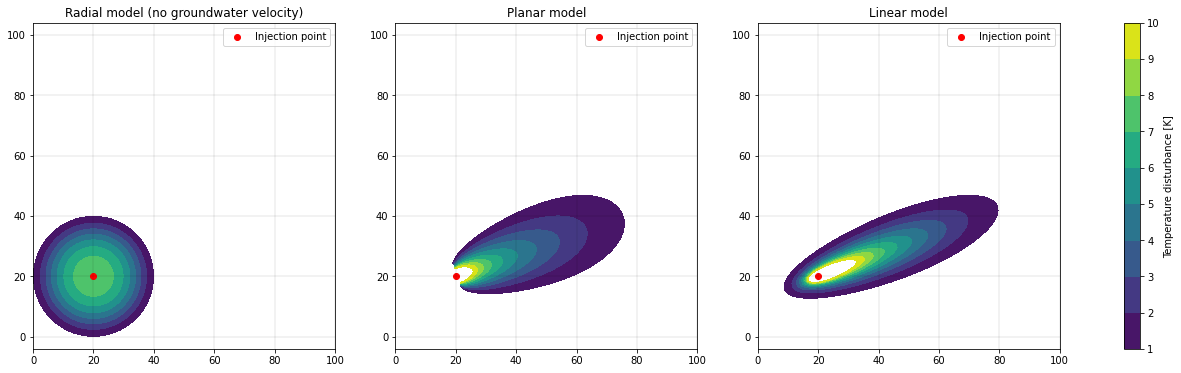

In [ ]:
%matplotlib inline
#We define the titles of our subplots
titles =["Radial model (no groundwater velocity)",
         "Planar model",
         "Linear model"]

results = [deltaT_rht, deltaT_paht, deltaT_laht]
 
fig, axs = plt.subplots(1,3, figsize=(23,6))
for i in range(3):
    ax = axs[i]
    ax.set_title(titles[i])
    ax.axis('equal')
    cf= ax.contourf(xi, yi, results[i], [1,2,3,4,5,6,7,8,9,10], cmap='viridis') # analytical contour (1 K disturbance)
    ax.grid(color='black', linestyle='-', linewidth=0.1)
    ax.scatter(X0, Y0, color='red', label = "Injection point")   
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.legend()
 
fig.colorbar(cf, ax=axs.ravel().tolist(), label = "Temperature disturbance [K]")
 
plt.show()

## Illustation in case of multiple installations

In case you want to calculate the thermal impact caused by several installations, you can iterate over your installations and calculate the total thermal impact (of course you have to assume that thermal impacts are additive which is not rigourously the case. However, this assumption can help to have an idea of the thermal stress of an higly sollicited area).

Let’s choose the linear model and calculate the thermal impact of three installations:

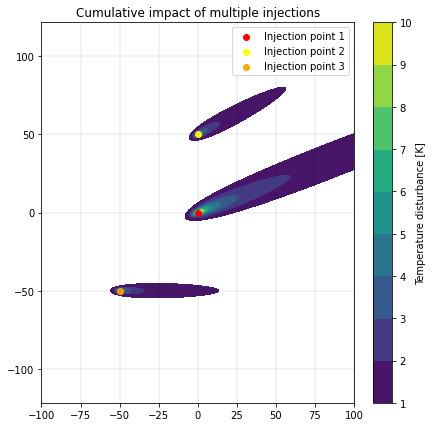

In [ ]:
#inistialize an array of 0 with the good size
deltaT_m = xi - xi 
 
#add the impact of the first instalation
X0_1, Y0_1 = 0, 0 #location of the first installation
deltaT_m += LAHT(xi, yi, X0_1, Y0_1, 20, time, 0.0002, 10, b, 5*va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)
 
#add the impact of the second instalation
X0_2, Y0_2 = 0, 50 #location of the second installation
deltaT_m += LAHT(xi, yi, X0_2, Y0_2, 25, time, 0.0001, 10, b , 5*va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)
 
#add the impact of the third instalation
X0_3, Y0_3 = -50, -50 #location of the third installation
deltaT_m += LAHT(xi, yi, X0_3, Y0_3, 0, time, 0.0001, 10, b, 5*va, n, C_m, C_w, alpha_L, alpha_T, lambda_m)
 
#Creation of the figure
fig, ax = plt.subplots(figsize=(7,7))
 
ax.set_title("Cumulative impact of multiple injections")
ax.axis('equal')
cf= ax.contourf(xi, yi, deltaT_m, [1,2,3,4,5,6,7,8,9,10], cmap='viridis')
ax.grid(color='black', linestyle='-', linewidth=0.1)
ax.scatter(X0_1, Y0_1, color='red', label = "Injection point 1")
ax.scatter(X0_2, Y0_2, color='yellow', label = "Injection point 2")
ax.scatter(X0_3, Y0_3, color='orange', label = "Injection point 3")   
 
ax.legend()
 
fig.colorbar(cf, label = "Temperature disturbance [K]")
 
plt.show()

## Exporting the results in a shapefile using shapely, pandas and geopandas

It can be convenient to export our result in a shapefile. With a shapefile, we can project the results over a geographic map in our favourite GIS (The procedure to plot these kind of result on basemaps or on interactive folium map is not covered in this article but will be presented in a future post) and cross the result with other geographical data.

In the following a procedure to transform your numpy array associated to the thermal disturbance into a geoDataframe is presented. We’ll finally export this geoDataframe as a shapefile.

Let’s first import the librairies we need to do that job:

In [ ]:
# uncomment the line below on the first run
#!pip install geopandas

In [ ]:
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame

Then, we can transform our numpy array calculated in the previous section into a pandas dataFrame:

In [ ]:
dat = np.array([xi, yi, deltaT_m]).reshape(3, -1).T
df = pd.DataFrame(dat)
df.columns = ['X', 'Y', 'DeltaT']
df = df.dropna()
df.head()

,X,Y,DeltaT
0,-100.000000,-100.0,2.373318e-10
1,-98.994975,-100.0,2.709839e-10
2,-97.989950,-100.0,3.092207e-10
3,-96.984925,-100.0,3.526389e-10
4,-95.979899,-100.0,4.019085e-10


Now, we can use shapely and geopandas to transforme the dataframe into a geodataframe. Fisrt a geometry field is created in our dataframe. Secondly, the geodataframe function is used sepecifying the geometry field of the dataframe.

In [ ]:
df['geometry'] = df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)
geopd = GeoDataFrame(df, geometry='geometry') #Here is you geodataframe
geopd.head()

,X,Y,DeltaT,geometry
0,-100.000000,-100.0,2.373318e-10,POINT (-100.000 -100.000)
1,-98.994975,-100.0,2.709839e-10,POINT (-98.995 -100.000)
2,-97.989950,-100.0,3.092207e-10,POINT (-97.990 -100.000)
3,-96.984925,-100.0,3.526389e-10,POINT (-96.985 -100.000)
4,-95.979899,-100.0,4.019085e-10,POINT (-95.980 -100.000)


Finally, our file can be exported using the to_file() method:

In [ ]:
#uncomment the line below to export your result

#geopd.to_file('my_result.shp', driver='ESRI Shapefile')

## Bibliography

[1] Pophillat, W., Attard, G., Bayer, P., Hecht-Méndez, J., & Blum, P. (2020). Analytical solutions for predicting thermal plumes of groundwater heat pump systems. Renewable Energy, 147, 2696-2707.

[2] Guimerà, J., Ortuño, F., Ruiz, E., Delos, A., & Pérez-Paricio, A. (2007, May). Influence of ground-source heat pumps on groundwater. In Conference Proceedings: European Geothermal Congress.

[3] Hähnlein, S., Molina-Giraldo, N., Blum, P., Bayer, P., & Grathwohl, P. (2010). Ausbreitung von Kältefahnen im Grundwasser bei Erdwärmesonden. Grundwasser, 15(2), 123-133.

[4] Kinzelbach, W. (1987). Numerische Methoden zur Modellierung des Transports von Schadstoffen im Grundwasser. Oldenbourg.